In [1]:
import py2neo
from py2neo import Node, Relationship, Graph, NodeMatcher
import pandas as pd
import time
import numpy as np

In [2]:
from absapi_aspect_class_prediction_engine import *

In [3]:
pred_engine()

absapi_aspect_class_prediction_engine.py loaded


In [4]:
#panda version
df=pd.read_csv("gbcfa_graphdata_with_aspects_clean.tsv", sep='\t',index_col = False, header=None, 
               names=["index","review_id","sentence_no","sentence","keyword","polarity","aspect_class"])
df.head() 

,index,review_id,sentence_no,sentence,keyword,polarity,aspect_class
0,NaN,2456,2,i bought the chromebook thinking that i will b...,chromebook,-0.1589,LAPTOP
1,0.0,2456,2,i bought the chromebook thinking that i will b...,connect,-0.3178,CONNECTIVITY
2,1.0,2456,3,"i could connect to citrix from my laptop, andr...",laptop,0.0000,LAPTOP
3,2.0,2456,3,"i could connect to citrix from my laptop, andr...",chromebook,0.0000,LAPTOP
4,3.0,2456,3,"i could connect to citrix from my laptop, andr...",connect,0.0000,CONNECTIVITY


In [5]:
reviews_count=len( df["sentence_no"].unique())
# ((5000-reviews_count)/5000)*100
#out of 5000 reviews 
reviews_count

15125

In [6]:
len(df)
# .count()

21705

In [7]:
aspect_classes = df["aspect_class"].unique()
aspect_classes

array(['LAPTOP', 'CONNECTIVITY', 'OS', 'PERFORMANCE', 'DISPLAY',
       'KEYBOARD', 'SUPPORT', 'BATTERY', 'FAN', 'HARDDRIVE', 'MULTIMEDIA',
       'SHIPPING', 'CPU ', 'MEMORY', 'OPTICAL_DRIVE', 'CHARGER',
       'MOTHERBOARD'], dtype=object)

In [8]:
#Number of keywords detected in dataset
print("Number of keywords detected in dataset is :",len(df["keyword"].unique()))

Number of keywords detected in dataset is : 92


In [9]:
df.describe()

,index,review_id,sentence_no,polarity
count,21704.000000,21705.000000,21705.000000,21705.000000
mean,10851.500000,2174.482700,15345.883068,0.139321
std,6265.549457,1761.513683,8936.377415,0.274378
min,0.000000,0.000000,2.000000,-0.787600
25%,5425.750000,542.000000,7610.000000,0.000000
50%,10851.500000,1668.000000,15300.000000,0.022500
75%,16277.250000,4006.000000,22993.000000,0.360900
max,21703.000000,4999.000000,30991.000000,0.852908


<H1>BUILD GRAPH</h1>

In [5]:
#connect to neo4j
G= Graph("bolt://localhost:7687",password="gbcfa")

In [6]:
G.run('''match(n) return count(n)''').data()

[{'count(n)': 19437}]

In [13]:
#unique keywords
# G.run('''

# //Constraints creation for users and services
# DROP CONSTRAINT ON (s:Review)
#        ASSERT s.review_id IS UNIQUE;
# ''')

# G.run('''
# DROP CONSTRAINT ON (u:Sentence)
#        ASSERT u.number IS UNIQUE

# ''')


# G.run('''
# DROP CONSTRAINT ON (u:Class)
#        ASSERT u.name IS UNIQUE

# ''')

# G.run('''
# DROP CONSTRAINT ON (u:Keyword)
#        ASSERT u.keyword IS UNIQUE

# ''')


In [14]:
# create constraints
# G.run('''

# //Constraints creation for users and services
# CREATE CONSTRAINT ON (s:Review)
#        ASSERT s.review_id IS UNIQUE;
# ''')

# G.run('''
# CREATE CONSTRAINT ON (u:Sentence)
#        ASSERT u.number IS UNIQUE

# ''')


# G.run('''
# CREATE CONSTRAINT ON (u:Class)
#        ASSERT u.name IS UNIQUE

# ''')

# G.run('''
# CREATE CONSTRAINT ON (u:Keyword)
#        ASSERT u.keyword IS UNIQUE

# ''')

In [15]:
# Create review nodes
n=0
# for rev in reviews.rdd.collect():
for index, row in df.iterrows():    
    n=n+1
    review_id = row["review_id"]
    G.run('''
    
    MERGE (rev:Review{review_id:$review_id})
    
    ''',parameters={'review_id':review_id}) 
                    
                    
print("Number of reviews created:", n)

Number of reviews created: 21705


In [16]:
# Create sentence nodes
n=0

# for row in df.rdd.collect():
for index, row in df.iterrows():  
    n = n+1
    sentence_no =  row["sentence_no"]
        
    sentence = row["sentence"]

    G.run(
        '''
    
    MERGE (sent:Sentence{number:$sentence_no, text:$sentence})
    
    ''', parameters={'sentence_no':sentence_no, "sentence":sentence})
                    
                    
print("Number of sentences created:", n)

Number of sentences created: 21705


In [17]:
#Create Aspect Class nodes 
n=0
# for cls in aspect_classes.rdd.collect():
for cls in aspect_classes:
#     print(cls)
    
#     CL = cls.aspect_class
    n = n + 1
    G.run(
    '''
    MERGE (class:Class{name:$class})
    
    ''', parameters={'class':cls}) 
print("Number of classes created:", n)

Number of classes created: 17


In [18]:
#Create keyword nodes
# aspect_classes = lbs
n=0

for aspect_class in aspect_classes:
    aspect_keywords=eval(aspect_class)
#     print(aspect_keywords)
    for keyword in aspect_keywords:
        n = n + 1
        G.run(
        '''
    
    MERGE (key:Keyword{keyword:$keyword})
    
    ''', parameters={'keyword':keyword})
                    
                    
print("Number of keywords created:", n)
        

Number of keywords created: 195


In [19]:
#Create [:BELONGS_TO ] relationships between keywords and ASPECT classes
aspect_classes = lbs
n=0

for aspect_class in aspect_classes:
    aspect_keywords=eval(aspect_class)
    for keyword in aspect_keywords:
        n = n + 1
        G.run(
        '''
    MATCH (key:Keyword{keyword:$keyword}),(class:Class{name:$class})
    with key,class
    MERGE (key)-[:BELONGS_TO]->(class)
    
    ''', parameters={'keyword':keyword,'class':aspect_class})
                    
                    
print("Number of [:BELONG_TO ] relationships created:", n)
            

Number of [:BELONG_TO ] relationships created: 195


In [20]:
# Create HAS_SENTENCE
n=0

# for row in df.rdd.collect():
for index, row in df.iterrows():    
    n = n+1
    sentence_no =  row["sentence_no"]
    review_id = row["review_id"]
        
#     sentence = row["sentence"]

    G.run(
        '''
    MATCH (rev:Review{review_id:$review_id}), (sent:Sentence{number:$sentence_no})
    MERGE (rev)-[:HAS_SENTENCE]->(sent)
    
    ''', parameters={'sentence_no':sentence_no, "review_id":review_id})
                    
                    
print("Number of [:HAS_SENTENCE] created:", n)

Number of [:HAS_SENTENCE] created: 21705


In [21]:
# Create HAS_OPINION_ON Relationship
# Create HAS_SENTENCE
n=0

# for row in df.rdd.collect():
for index, row in df.iterrows():  
    n = n+1
    sentence_no =  row["sentence_no"]
    keyword = row["keyword"]
    polarity = row["polarity"]
        
#     sentence = row["sentence"]

    G.run(
        '''
    MATCH (key:Keyword{keyword:$keyword}), (sent:Sentence{number:$sentence_no})
    MERGE (sent)-[:HAS_OPINION_ON{polarity:$polarity}]->(key)
    
    ''', parameters={'sentence_no':sentence_no, "keyword":keyword,'polarity':polarity})
                    
                    
print("Number of [:HAS_OPINION_ON{polarity:$polarity}] created:", n)

Number of [:HAS_OPINION_ON{polarity:$polarity}] created: 21705


<h1>CREATE FULLTEXT INDEX</h1>

In [37]:
# G.run('''
# CALL db.index.fulltext.createNodeIndex("sentenceIndex",
# ["Sentence"], 
# ["text"])
# ''')

(No data)




<H2>TEST QUERIES</H2>

In [7]:
'''   (rev:Review)-[:HAS_SENTENCE]->(sent:Sentence)- [o:HAS_OPINION_ON]->
(key:Keyword)-[:BELONGS_TO]-> (class:Class) return  rev,o,class'''

'   (rev:Review)-[:HAS_SENTENCE]->(sent:Sentence)- [o:HAS_OPINION_ON]->\n(key:Keyword)-[:BELONGS_TO]-> (class:Class) return  rev,o,class'

In [7]:
rev_class_bipartite = G.run(
    '''    MATCH (rev:Review)-[:HAS_SENTENCE]->(sent:Sentence)-[o:HAS_OPINION_ON]->(key:Keyword)-[:BELONGS_TO]-> (class:Class) return  rev,o,class 
   '''
).data()


In [8]:
pd.DataFrame(rev_class_bipartite).head(5)

,rev,o,class
0,{'review_id': 1092},{'polarity': 0.0},{'name': 'HARDDRIVE'}
1,{'review_id': 1092},{'polarity': 0.0},{'name': 'HARDDRIVE'}
2,{'review_id': 39},{'polarity': 0.0},{'name': 'HARDDRIVE'}
3,{'review_id': 92},{'polarity': 0.2023},{'name': 'HARDDRIVE'}
4,{'review_id': 1426},{'polarity': -0.16206666666666664},{'name': 'HARDDRIVE'}


In [9]:
import time
t0=time.time()
rev_projected =  G.run('''//class projection
MATCH 
 (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)-[:HAS_SENTENCE]->(sent2:Sentence)- [o2:HAS_OPINION_ON]->(key2:Keyword)-[:BELONGS_TO]-> (class2:Class)
WHERE class1<>class2
WITH class1,class2,count(DISTINCT(rev)) as rev_intsct_count
return class1.name,class2.name,rev_intsct_count
   //return  rev.review_id,o.polarity,class.name
 ''').data()
t1=time.time()
print("Time: ", t1-t0)
rev_projection = pd.DataFrame(rev_projected)

Time:  0.5259783267974854


<h1>ANALYSIS STARTS HERE...............</h1>

In [10]:
import time
t0=time.time()
class_IDs =  G.run('''//class projection
MATCH 
 (class:Class)
 
 return ID(class) as id
 ''').data()
t1=time.time()
print("Time: ", t1-t0)
class_IDs = pd.DataFrame(class_IDs)

Time:  0.02200031280517578


In [11]:
import time
t0=time.time()
idd1=23185
class_IDs =  G.run('''//class projection
MATCH 
 (class:Class) 
 
 //where id(class)=$id
 
 return ID(class) as id
 ''',parameters={'id':idd1}).data()
t1=time.time()
print("Time: ", t1-t0)
print(class_IDs)
# class_IDs = pd.DataFrame(class_IDs)

Time:  0.01297450065612793
[{'id': 15267}, {'id': 15268}, {'id': 15269}, {'id': 15270}, {'id': 15271}, {'id': 15272}, {'id': 15273}, {'id': 15274}, {'id': 15275}, {'id': 15276}, {'id': 15277}, {'id': 15278}, {'id': 15279}, {'id': 15280}, {'id': 15281}, {'id': 15282}, {'id': 15283}, {'id': 15477}]


In [30]:
class_IDs = pd.DataFrame(class_IDs)
id_list =list(class_IDs["id"])
id_list

[15267,
 15268,
 15269,
 15270,
 15271,
 15272,
 15273,
 15274,
 15275,
 15276,
 15277,
 15278,
 15279,
 15280,
 15281,
 15282,
 15283,
 15477]

<h2>Most mentioned aspect class</h2>

In [13]:
most_mentioned = G.run('''MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
      return class1.name, count(o1) as counts order by counts desc''').data()

In [14]:
most_mentioned

[{'class1.name': 'LAPTOP', 'counts': 10747},
 {'class1.name': 'DISPLAY', 'counts': 2050},
 {'class1.name': 'CONNECTIVITY', 'counts': 1687},
 {'class1.name': 'OS', 'counts': 1554},
 {'class1.name': 'PERFORMANCE', 'counts': 1489},
 {'class1.name': 'KEYBOARD', 'counts': 1444},
 {'class1.name': 'BATTERY', 'counts': 1003},
 {'class1.name': 'SUPPORT', 'counts': 467},
 {'class1.name': 'MULTIMEDIA', 'counts': 389},
 {'class1.name': 'CPU', 'counts': 205},
 {'class1.name': 'FAN', 'counts': 186},
 {'class1.name': 'MEMORY', 'counts': 148},
 {'class1.name': 'HARDDRIVE', 'counts': 109},
 {'class1.name': 'SHIPPING', 'counts': 95},
 {'class1.name': 'CHARGER', 'counts': 81},
 {'class1.name': 'OPTICAL_DRIVE', 'counts': 46},
 {'class1.name': 'MOTHERBOARD', 'counts': 5}]

<h2>Most positive mentioned aspect class</h2>

In [15]:
pos_most_mentioned = G.run('''MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
     where o1.polarity>0 return class1.name, count(o1) as counts order by counts desc''').data()

In [16]:
pos_most_mentioned

[{'class1.name': 'LAPTOP', 'counts': 5533},
 {'class1.name': 'DISPLAY', 'counts': 1046},
 {'class1.name': 'KEYBOARD', 'counts': 905},
 {'class1.name': 'PERFORMANCE', 'counts': 816},
 {'class1.name': 'OS', 'counts': 689},
 {'class1.name': 'CONNECTIVITY', 'counts': 647},
 {'class1.name': 'BATTERY', 'counts': 602},
 {'class1.name': 'MULTIMEDIA', 'counts': 202},
 {'class1.name': 'SUPPORT', 'counts': 179},
 {'class1.name': 'CPU', 'counts': 96},
 {'class1.name': 'FAN', 'counts': 77},
 {'class1.name': 'MEMORY', 'counts': 62},
 {'class1.name': 'SHIPPING', 'counts': 48},
 {'class1.name': 'HARDDRIVE', 'counts': 41},
 {'class1.name': 'CHARGER', 'counts': 32},
 {'class1.name': 'OPTICAL_DRIVE', 'counts': 20}]

<h2>Most negative mentioned aspect class</h2>

In [17]:
neg_most_mentioned = G.run('''MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
     where o1.polarity<0 return class1.name, count(o1) as counts order by counts desc''').data()

In [18]:
neg_most_mentioned

[{'class1.name': 'LAPTOP', 'counts': 1555},
 {'class1.name': 'DISPLAY', 'counts': 449},
 {'class1.name': 'CONNECTIVITY', 'counts': 332},
 {'class1.name': 'OS', 'counts': 320},
 {'class1.name': 'KEYBOARD', 'counts': 223},
 {'class1.name': 'PERFORMANCE', 'counts': 191},
 {'class1.name': 'BATTERY', 'counts': 140},
 {'class1.name': 'SUPPORT', 'counts': 136},
 {'class1.name': 'MULTIMEDIA', 'counts': 83},
 {'class1.name': 'FAN', 'counts': 73},
 {'class1.name': 'CPU', 'counts': 35},
 {'class1.name': 'HARDDRIVE', 'counts': 32},
 {'class1.name': 'MEMORY', 'counts': 31},
 {'class1.name': 'CHARGER', 'counts': 22},
 {'class1.name': 'SHIPPING', 'counts': 20},
 {'class1.name': 'OPTICAL_DRIVE', 'counts': 12},
 {'class1.name': 'MOTHERBOARD', 'counts': 3}]

<h2>Most neutral mentioned aspect class</h2>

In [19]:
neu_most_mentioned = G.run('''MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
     where o1.polarity=0 return class1.name, count(o1) as counts order by counts desc''').data()

In [20]:
neu_most_mentioned

[{'class1.name': 'LAPTOP', 'counts': 3659},
 {'class1.name': 'CONNECTIVITY', 'counts': 708},
 {'class1.name': 'DISPLAY', 'counts': 555},
 {'class1.name': 'OS', 'counts': 545},
 {'class1.name': 'PERFORMANCE', 'counts': 482},
 {'class1.name': 'KEYBOARD', 'counts': 316},
 {'class1.name': 'BATTERY', 'counts': 261},
 {'class1.name': 'SUPPORT', 'counts': 152},
 {'class1.name': 'MULTIMEDIA', 'counts': 104},
 {'class1.name': 'CPU', 'counts': 74},
 {'class1.name': 'MEMORY', 'counts': 55},
 {'class1.name': 'HARDDRIVE', 'counts': 36},
 {'class1.name': 'FAN', 'counts': 36},
 {'class1.name': 'CHARGER', 'counts': 27},
 {'class1.name': 'SHIPPING', 'counts': 27},
 {'class1.name': 'OPTICAL_DRIVE', 'counts': 14},
 {'class1.name': 'MOTHERBOARD', 'counts': 2}]

<h2>Generate Opinion Statistics for the 17 aspect classes of the product</h2>

In [36]:
aspect_class_opinion_stats=[]
id_list=list(class_IDs.id)

for ID in id_list:

    classid=ID
    all_opinions = G.run('''//MATCH (class:Class)
            //WHERE id(class)=$classid
            //WITH class
           // MATCH
         MATCH (class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)
         WHERE id(class)=$classid
         //<-[:HAS_SENTENCE]-(rev:Review)
         //count(o1) as all_counts

         RETURN class.name as aspect_class, count(o1) as all_counts


         ''',parameters={'classid':classid}).data()
    
    if  len(all_opinions)==0:
        print("nothing here xxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
        
        cname=G.run('''MATCH(n:Class) 
                where id(n)=$classid  
                return n.name as name
                ''',parameters={'classid':classid}).data()
        print(cname[0]["name"])
        all_opinions=[]
        all_opinions.append({'aspect_class':cname[0]["name"]})
        all_opinions[0]["all_counts"]=0
        print(all_opinions)
    print("all: ",len(all_opinions))
    print("all xxxxxx",all_opinions)

    neg_opinions = G.run('''MATCH (class:Class)
            WHERE id(class)=$classid
         MATCH 
         (class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
         where o1.polarity<0 

         RETURN count(o1) as neg_counts


         ''',parameters={'classid':classid}).data()
    
    if len( neg_opinions)==0:
        neg_opinions=[]
        neg_opinions.apprend({"neg_counts":0})
    print("negs: ",len(neg_opinions))
    print(neg_opinions)

    pos_opinions = G.run('''MATCH (class:Class)
            WHERE id(class)=$classid
         MATCH 
         (class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
         where o1.polarity>0 

        RETURN count(o1) as pos_counts


         ''',parameters={'classid':classid}).data()
    
    if len(pos_opinions)==0:
        pos_opinions=[]
        pos_opinions.apprend({"pos_counts":0})

    neu_opinions = G.run('''MATCH (class:Class)
            WHERE id(class)=$classid
         MATCH 
         (class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)
         where o1.polarity=0

         RETURN count(o1) as neu_counts


         ''',parameters={'classid':classid}).data()
    
    if  len(neu_opinions)==0:
        neu_opinions=[]
        neu_opinions.apprend({"neu_counts":0})

    
    print("neutrals: ",len(neu_opinions))
    print(neu_opinions)
    
    
    aspect_class_opinion_stats.append([all_opinions[0]['aspect_class'], 
                                       all_opinions[0]['all_counts'],
                                       pos_opinions[0]['pos_counts'],
#                                        pos_opinions[0]['pos_counts']/all_opinions[0]['all_counts']*100,
                                       neg_opinions[0]['neg_counts'],
#                                        neg_opinions[0]['neg_counts']/all_opinions[0]['all_counts']*100, 
                                       neu_opinions[0]['neu_counts']
#                                        neu_opinions[0]['neu_counts']/all_opinions[0]['all_counts']*100
                                      ])

all:  1
all xxxxxx [{'aspect_class': 'HARDDRIVE', 'all_counts': 109}]
negs:  1
[{'neg_counts': 32}]
neutrals:  1
[{'neu_counts': 36}]
all:  1
all xxxxxx [{'aspect_class': 'BATTERY', 'all_counts': 1003}]
negs:  1
[{'neg_counts': 140}]
neutrals:  1
[{'neu_counts': 261}]
all:  1
all xxxxxx [{'aspect_class': 'CHARGER', 'all_counts': 81}]
negs:  1
[{'neg_counts': 22}]
neutrals:  1
[{'neu_counts': 27}]
all:  1
all xxxxxx [{'aspect_class': 'CONNECTIVITY', 'all_counts': 1687}]
negs:  1
[{'neg_counts': 332}]
neutrals:  1
[{'neu_counts': 708}]
all:  1
all xxxxxx [{'aspect_class': 'CPU', 'all_counts': 205}]
negs:  1
[{'neg_counts': 35}]
neutrals:  1
[{'neu_counts': 74}]
all:  1
all xxxxxx [{'aspect_class': 'DISPLAY', 'all_counts': 2050}]
negs:  1
[{'neg_counts': 449}]
neutrals:  1
[{'neu_counts': 555}]
all:  1
all xxxxxx [{'aspect_class': 'FAN', 'all_counts': 186}]
negs:  1
[{'neg_counts': 73}]
neutrals:  1
[{'neu_counts': 36}]
all:  1
all xxxxxx [{'aspect_class': 'KEYBOARD', 'all_counts': 1444}]

In [35]:
# [all_opinions[0]['aspect_class'], all_opinions[0]['all_counts'],pos_opinions[0]['pos_counts'],pos_opinions[0]['pos_counts']/all_opinions[0]['all_counts']*100,neg_opinions[0]['neg_counts'],neg_opinions[0]['neg_counts']/all_opinions[0]['all_counts']*100, neu_opinions[0]['neu_counts'], neu_opinions[0]['neu_counts']/all_opinions[0]['all_counts']*100]


ABSAPI_stats = pd.DataFrame(aspect_class_opinion_stats,columns=["aspect_class",
                                                                "all_counts",
                                                                "pos_counts",
                                                                "neg_counts",
                                                                "neu_counts"
                                                                ])



ABSAPI_stats.sort_values(['all_counts'], ascending=False)

,aspect_class,all_counts,pos_counts,neg_counts,neu_counts
8,LAPTOP,10747,5533,1555,3659
5,DISPLAY,2050,1046,449,555
3,CONNECTIVITY,1687,647,332,708
13,OS,1554,689,320,545
14,PERFORMANCE,1489,816,191,482
7,KEYBOARD,1444,905,223,316
1,BATTERY,1003,602,140,261
16,SUPPORT,467,179,136,152
11,MULTIMEDIA,389,202,83,104
4,CPU,205,96,35,74


fig6


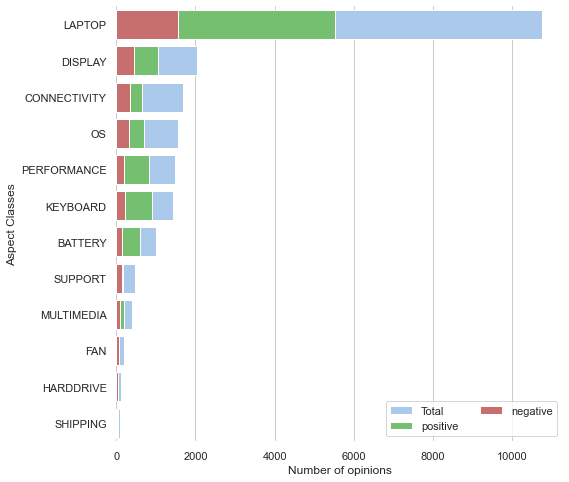

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))


data= ABSAPI_stats.sort_values(['all_counts'], ascending=False)
data= data[['aspect_class','all_counts','neu_counts','pos_counts', 'neg_counts']]
# data

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="all_counts", y="aspect_class", data=data,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="pos_counts", y="aspect_class", data=data,
            label="positive", color="g")


# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="neg_counts", y="aspect_class", data=data,
            label="negative", color="r")

# # Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="neu_counts", y="aspect_class", data=data,
#             label="neutral", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 12080), ylabel="Aspect Classes", xlabel="Number of opinions")
ax.set( ylabel="Aspect Classes", xlabel="Number of opinions")
sns.despine(left=True, bottom=True)
print("fig6")

<h1>Keyword Stats</h1>

<h2>Generate Opinion Statistics for the top 20 aspect keywords of the product</h2>

In [57]:
import time
t0=time.time()

keyword_IDs =  G.run('''//class projection
MATCH  (s:Sentence)-[o:HAS_OPINION_ON]->(k:Keyword) 
  
 return distinct(ID(k)) as id
 ''').data()
t1=time.time()
print("Time: ", t1-t0)
print(keyword_IDs)
# class_IDs = pd.DataFrame(class_IDs)


Time:  0.04799938201904297
[{'id': 23202}, {'id': 23203}, {'id': 23206}, {'id': 23207}, {'id': 23208}, {'id': 23209}, {'id': 23210}, {'id': 23211}, {'id': 23212}, {'id': 23215}, {'id': 23216}, {'id': 23217}, {'id': 23219}, {'id': 23220}, {'id': 23221}, {'id': 23222}, {'id': 23223}, {'id': 23224}, {'id': 23225}, {'id': 23226}, {'id': 23227}, {'id': 23228}, {'id': 23229}, {'id': 23231}, {'id': 23232}, {'id': 23233}, {'id': 23234}, {'id': 23235}, {'id': 23236}, {'id': 23237}, {'id': 23238}, {'id': 23239}, {'id': 23240}, {'id': 23242}, {'id': 23245}, {'id': 23246}, {'id': 23247}, {'id': 23248}, {'id': 23249}, {'id': 23250}, {'id': 23251}, {'id': 23254}, {'id': 23255}, {'id': 23256}, {'id': 23257}, {'id': 23258}, {'id': 23259}, {'id': 23260}, {'id': 23261}, {'id': 23262}, {'id': 23263}, {'id': 23264}, {'id': 23266}, {'id': 23267}, {'id': 23268}, {'id': 23270}, {'id': 23277}, {'id': 23278}, {'id': 23280}, {'id': 23281}, {'id': 23282}, {'id': 23284}, {'id': 23285}, {'id': 23286}, {'id': 23288

In [58]:

keyword_IDs = pd.DataFrame(keyword_IDs)
Key_id_list =list(keyword_IDs["id"])
# Key_id_list

In [59]:
keyword_opinion_stats=[]
for ID in Key_id_list:
    keyid=ID
    all_opinions=G.run('''
    MATCH (k:Keyword)
    WHERE id(k)=$keyid 
    match (s:Sentence)-[o:HAS_OPINION_ON]->(k) 
    //with count(o.polarity) as co,k
    //where co>0 
    return k.keyword as keyword,count(o.polarity) as all_counts''',parameters={'keyid':keyid}).data()
    
    neg_opinions = G.run('''
    MATCH (k:Keyword)
    WHERE id(k)=$keyid 
    match (s:Sentence)-[o:HAS_OPINION_ON]->(k) 
    //with count(o.polarity) as co,k
    where o.polarity<0 
    return count(o.polarity) as neg_counts''',parameters={'keyid':keyid}).data()
    
    pos_opinions = G.run('''
    MATCH (k:Keyword)
    WHERE id(k)=$keyid 
    match (s:Sentence)-[o:HAS_OPINION_ON]->(k) 
    //with count(o.polarity) as co,k
    where o.polarity>0 
    return count(o.polarity) as pos_counts''',parameters={'keyid':keyid}).data()
    
    neu_opinions = G.run('''
    MATCH (k:Keyword)
    WHERE id(k)=$keyid 
    match (s:Sentence)-[o:HAS_OPINION_ON]->(k) 
    //with count(o.polarity) as co,k
    where o.polarity=0 
    return count(o.polarity) as neu_counts''',parameters={'keyid':keyid}).data()

    
#     print(allkey_counts)
    keyword_opinion_stats.append([all_opinions[0]['keyword'], all_opinions[0]['all_counts'],pos_opinions[0]['pos_counts'],neg_opinions[0]['neg_counts'],neu_opinions[0]['neu_counts']])
# keyword_opinion_stats    

In [60]:
Keyword_stats = pd.DataFrame(keyword_opinion_stats,columns=["keyword","all_counts","pos_counts","neg_counts","neu_counts"])



Keyword_stats=Keyword_stats.sort_values(['pos_counts'], ascending=False)

Keyword_stats20=Keyword_stats.head(20)
Keyword_stats20=Keyword_stats20.sort_values('all_counts', ascending=False)

figure7


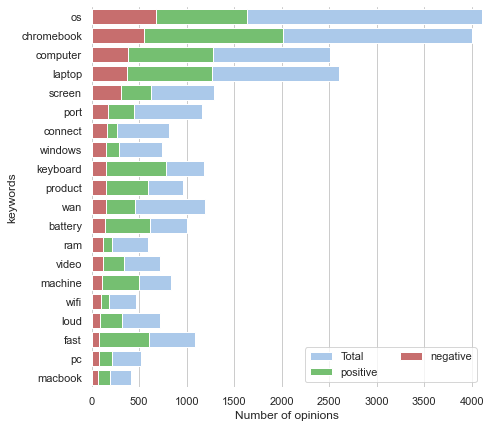

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))


data= Keyword_stats20.sort_values(['neg_counts'], ascending=False)
data= data[['keyword','all_counts','neu_counts','pos_counts', 'neg_counts']]
# data

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="all_counts", y="keyword", data=data,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="pos_counts", y="keyword", data=data,
            label="positive", color="g")


# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="neg_counts", y="keyword", data=data,
            label="negative", color="r")

# # Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="neu_counts", y="aspect_class", data=data,
#             label="neutral", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 4110), ylabel="keywords", xlabel="Number of opinions")
sns.despine(left=True, bottom=True)
print("figure7")

<h2>Generate Opinion Statistics for the pairs of the top 20 aspect classes of the product</h2>

In [62]:
keynames=list(Keyword_stats20['keyword'])

keys=[]

# for key in keynames:
keywordids= G.run('''match (k:Keyword)
                    WHERE k.keyword IN $keynames 
                    RETURN ID(k) as keyid''',parameters={'keynames':keynames}).data()

#     keys



top20_keyword_ids=pd.DataFrame(keywordids)


In [63]:
key_id_list=list(top20_keyword_ids['keyid'])

key_co_mentions=[]
from itertools import combinations

key_id_pairs=[]

key_id_pairs=combinations(key_id_list, 2)
key_id_pairs


for comb in key_id_pairs:
    c=list(comb)
    keyword1_id= c[0]
    keyword2_id= c[1]
#     print(keyword1_id,keyword1_id)
    keyword_projection =  G.run('''MATCH
    (key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent:Sentence)-[o2:HAS_OPINION_ON]->(key2:Keyword)
    WHERE ID(key1)=$keyword1_id AND ID(key2)=$keyword2_id
    WITH key1,key2, COUNT(DISTINCT(sent)) as sent_intsct_count
    RETURN  key1.keyword  as keywordA, key2.keyword as keywordB, sent_intsct_count''',
                           parameters={'keyword1_id':keyword1_id,'keyword2_id':keyword2_id}).data()
    
    keyword_co_pos =  G.run('''MATCH
    (key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent:Sentence)-[o2:HAS_OPINION_ON]->(key2:Keyword)
    WHERE ID(key1)=$keyword1_id AND ID(key2)=$keyword2_id AND o1.polarity>0 AND o2.polarity>0
    WITH key1,key2, COUNT(DISTINCT(sent)) as pos_intsct_count
    RETURN   pos_intsct_count''',
                           parameters={'keyword1_id':keyword1_id,'keyword2_id':keyword2_id}).data()
    
    keyword_co_neg =  G.run('''MATCH
    (key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent:Sentence)-[o2:HAS_OPINION_ON]->(key2:Keyword)
    WHERE ID(key1)=$keyword1_id AND ID(key2)=$keyword2_id AND o1.polarity>0 AND o2.polarity<0
    WITH key1,key2, COUNT(DISTINCT(sent)) as neg_intsct_count
    RETURN   key1,key2, neg_intsct_count''',
                           parameters={'keyword1_id':keyword1_id,'keyword2_id':keyword2_id}).data()
    
    if len(keyword_projection)>0:
        
        if len(keyword_co_neg)==0:
            key_co_mentions.append([
                                keyword_projection[0]['keywordA'], 
                                keyword_projection[0]['keywordB'], 
                                keyword_projection[0]['sent_intsct_count'],
                                keyword_co_pos[0]['pos_intsct_count'],
                                0 ])
        else:
        

            key_co_mentions.append([
                                    keyword_projection[0]['keywordA'], 
                                    keyword_projection[0]['keywordB'], 
                                    keyword_projection[0]['sent_intsct_count'],
                                    keyword_co_pos[0]['pos_intsct_count'],
                                    keyword_co_neg[0]['neg_intsct_count']
            ])





In [65]:

Keyword_co_mentions_stats = pd.DataFrame(key_co_mentions,columns=["keyword1","keyword2","total","positive","negative"])
Keyword_co_mentions_stats.sort_values(["negative","total"], ascending=False).head(20)

,keyword1,keyword2,total,positive,negative
6,os,chromebook,662,212,26
5,os,laptop,500,179,19
112,chromebook,computer,326,128,17
3,os,port,244,75,14
119,chromebook,screen,156,54,14
0,os,windows,227,73,13
16,os,keyboard,227,107,12
100,laptop,computer,204,77,11
1,os,wifi,92,25,11
7,os,computer,447,153,9


In [66]:
Keyword_co_mentions_stats = pd.DataFrame(key_co_mentions,columns=["keyword1","keyword2","total","positive","negative"])
keypairstats=Keyword_co_mentions_stats.sort_values(["total","negative"], ascending=False).head(20)
keypairstats

,keyword1,keyword2,total,positive,negative
6,os,chromebook,662,212,26
5,os,laptop,500,179,19
7,os,computer,447,153,9
99,laptop,chromebook,389,139,9
15,os,video,359,135,5
112,chromebook,computer,326,128,17
3,os,port,244,75,14
14,os,screen,236,79,9
2,os,wan,231,69,6
0,os,windows,227,73,13


In [67]:
keypairstats["pairs"]=keypairstats["keyword1"] + "," + keypairstats["keyword2"] 
keypairstats

,keyword1,keyword2,total,positive,negative,pairs
6,os,chromebook,662,212,26,"os,chromebook"
5,os,laptop,500,179,19,"os,laptop"
7,os,computer,447,153,9,"os,computer"
99,laptop,chromebook,389,139,9,"laptop,chromebook"
15,os,video,359,135,5,"os,video"
112,chromebook,computer,326,128,17,"chromebook,computer"
3,os,port,244,75,14,"os,port"
14,os,screen,236,79,9,"os,screen"
2,os,wan,231,69,6,"os,wan"
0,os,windows,227,73,13,"os,windows"


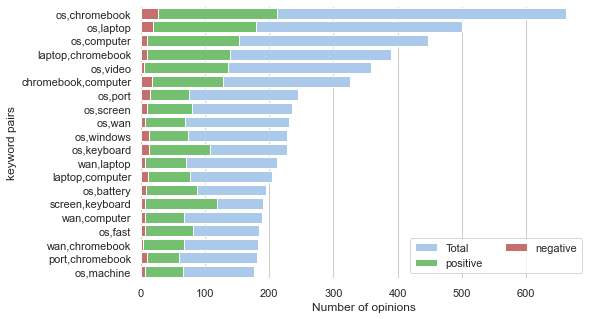

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))


# data= Keyword_stats20.sort_values(['all_counts'], ascending=False)
data= keypairstats[['total','positive','negative','pairs']]
# data

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="pairs", data=data,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="positive", y="pairs", data=data,
            label="positive", color="g")


# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="negative", y="pairs", data=data,
            label="negative", color="r")

# # Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="neu_counts", y="aspect_class", data=data,
#             label="neutral", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 665), ylabel="keyword pairs", xlabel="Number of opinions")
ax.set( ylabel="keyword pairs", xlabel="Number of opinions")
sns.despine(left=True, bottom=True)

<H2>Top N aspect class co-mentions</H2>

In [71]:
id_list=list(class_IDs.id)

co_mentions=[]
from itertools import combinations

id_pairs=[]

id_pairs=combinations(id_list, 2)
for comb in id_pairs:
    c=list(comb)
    class1_id= c[0]
    class2_id=c[1]
#     print(class1,class2)
    rev_projected =  G.run('''//class projection
    MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)-[:HAS_SENTENCE]->(sent2:Sentence)- [o2:HAS_OPINION_ON]->(key2:Keyword)-[:BELONGS_TO]-> (class2:Class)
    WHERE ID(class1)=$class1_id and ID(class2)=$class2_id
    WITH class1,class2,count(DISTINCT(rev)) as rev_intsct_count
    return class1.name as classA,class2.name as classB,rev_intsct_count
       //return  rev.review_id,o.polarity,class.name
     ''', parameters={'class1_id':class1_id, "class2_id":class2_id}).data()
    if len(rev_projected)>0:
        
#         print([rev_projected[0]["classA"],rev_projected[0]["classB"],rev_projected[0]["rev_intsct_count"]])
        
        co_mentions.append([rev_projected[0]["classA"],rev_projected[0]["classB"],rev_projected[0]["rev_intsct_count"]])
#     //=pd.DataFrame(rev_projected)
#     print(comb)


In [72]:
len(co_mentions)

126

In [73]:
co_mentioned = pd.DataFrame(co_mentions,columns=["class1","class2","count"])
# co_mentioned.head()
sorted_co_mentioned = co_mentioned.sort_values('count', ascending=False)

N=10
sorted_co_mentioned.head(N)


,class1,class2,count
1,OS,LAPTOP,1632
16,CONNECTIVITY,LAPTOP,1534
0,OS,CONNECTIVITY,1106
33,LAPTOP,DISPLAY,1033
32,LAPTOP,PERFORMANCE,926
34,LAPTOP,KEYBOARD,801
4,OS,DISPLAY,776
37,LAPTOP,BATTERY,770
19,CONNECTIVITY,DISPLAY,706
3,OS,PERFORMANCE,668


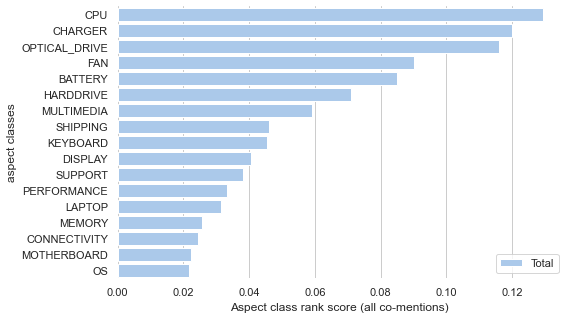

In [75]:
import networkx as nx
Dall=nx.DiGraph()
Dall.add_weighted_edges_from(co_mentions)
all_pagerank=nx.pagerank(Dall)

# all_pagerank

df_all_pagerank=pd.DataFrame.from_dict(all_pagerank,orient='index',columns=["rank"])
# df_negPageRank['aspect_class']=df_negPageRank.index
df_all_pagerank.reset_index(level=0, inplace=True)
df_all_pagerank=df_all_pagerank.rename(columns={'index':'aspect_class'})
df_all_pagerank=df_all_pagerank.sort_values('rank', ascending=False)
# df_all_pagerank

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# data=df_all_pagerank

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="rank", y="aspect_class", data=df_all_pagerank,
            label="Total", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="aspect classes", xlabel="Aspect class rank score (all co-mentions) ")
# ax.set(xlim=(0, 1), ylabel="aspect classes", xlabel="Aspect class rank score (all co-mentions) ")
sns.despine(left=True, bottom=True)

<H2>Top N negative aspect class co-mentoins</H2>

In [76]:
neg_co_mentions=[]

id_pairs=combinations(id_list, 2)
for comb in id_pairs:
    c=list(comb)
    class1_id= c[0]
    class2_id=c[1]
#     print(class1_id,class2_id)
    neg_rev_projected =  G.run('''//class projection
    MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)-[:HAS_SENTENCE]->(sent2:Sentence)- [o2:HAS_OPINION_ON]->(key2:Keyword)-[:BELONGS_TO]-> (class2:Class)
    WHERE ID(class1)=$class1_id and ID(class2)=$class2_id and o1.polarity<0 and o2.polarity<0
    WITH class1,class2,count(DISTINCT(rev)) as rev_intsct_count
    return class1.name as classA,class2.name as classB,rev_intsct_count
       //return  rev.review_id,o.polarity,class.name
     ''', parameters={'class1_id':class1_id, "class2_id":class2_id}).data()
    if len(neg_rev_projected)>0:
        
#         print([rev_projected[0]["classA"],rev_projected[0]["classB"],rev_projected[0]["rev_intsct_count"]])
        
        neg_co_mentions.append([neg_rev_projected[0]["classA"],neg_rev_projected[0]["classB"],neg_rev_projected[0]["rev_intsct_count"]])
#     //=pd.DataFrame(rev_projected)
#     print(comb)


In [78]:
len(neg_co_mentions)

110

In [79]:
 neg_co_mentioned = pd.DataFrame( neg_co_mentions,columns=["class1","class2","count"])
# co_mentioned.head()
sorted_neg_co_mentioned =  neg_co_mentioned.sort_values('count', ascending=False)

N=10
sorted_neg_co_mentioned.head(N)

,class1,class2,count
1,OS,LAPTOP,264
15,CONNECTIVITY,LAPTOP,223
31,LAPTOP,DISPLAY,169
0,OS,CONNECTIVITY,146
4,OS,DISPLAY,108
32,LAPTOP,KEYBOARD,98
30,LAPTOP,PERFORMANCE,89
18,CONNECTIVITY,DISPLAY,84
34,LAPTOP,MULTIMEDIA,77
5,OS,KEYBOARD,74


<h3>Create negative co-mentioned projection of aspect classes</h3>
<h3>then compute weighted pagerank</h3>

In [80]:
import networkx as nx
D=nx.DiGraph()
D.add_weighted_edges_from(neg_co_mentions)
neg_pagerank=nx.pagerank(D)


# print(neg_pagerank)

In [81]:
type(neg_pagerank)

dict

In [82]:
df_negPageRank=pd.DataFrame.from_dict(neg_pagerank,orient='index',columns=["rank"])
df_negPageRank.reset_index(level=0, inplace=True)
df_negPageRank=df_negPageRank.rename(columns={'index':'aspect_class'})
df_negPageRank=df_negPageRank.sort_values('rank', ascending=False)

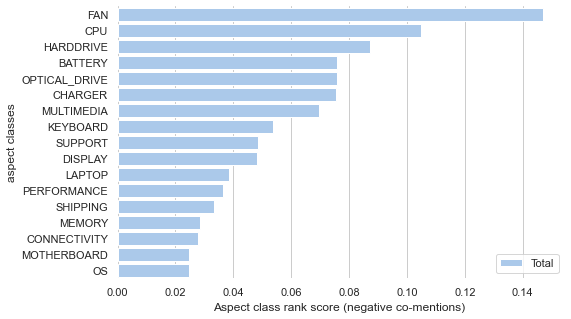

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))


# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="rank", y="aspect_class", data=df_negPageRank,
            label="Total", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 1), ylabel="aspect classes", xlabel="Aspect class rank score (negative co-mentions) ")
ax.set(ylabel="aspect classes", xlabel="Aspect class rank score (negative co-mentions) ")
sns.despine(left=True, bottom=True)

dd=pd.DataFrame(
[
['CONNECTIVITY', 0.024816891638914033],
 ['DISPLAY', 0.02698565012997087],
 ['SHIPPING', 0.025105722407523946],
 ['HARDDRIVE', 0.02724380807013692],
 ['CPU', 0.026713666999741606],
 ['MULTIMEDIA', 0.03371812833562775],
 ['OPTICAL_DRIVE', 0.026218567538212743],
 ['FAN', 0.031075395847498504],
 ['CHARGER', 0.026549134916688914],
 ['PERFORMANCE', 0.049653105376496205],
 ['BATTERY', 0.0519322981713498],
 ['KEYBOARD', 0.061616463789575415],
 ['MEMORY', 0.05102677552972876],
 ['OS', 0.12329533573094356],
 ['MOTHERBOARD',0.025058499734221088],
 ['SUPPORT',0.06912429432291131],
 ['LAPTOP',0.31986626146045866]
], columns=["Aspect class","ClassRank"])

<H2>Top N postive co-mentoins</H2>

In [84]:
pos_co_mentions=[]

id_pairs=combinations(id_list, 2)
for comb in id_pairs:
    c=list(comb)
    class1_id= c[0]
    class2_id=c[1]
#     print(class1_id,class2_id)
    pos_rev_projected =  G.run('''//class projection
    MATCH 
     (class1:Class)<-[:BELONGS_TO]-(key1:Keyword)<-[o1:HAS_OPINION_ON]-(sent1:Sentence)<-[:HAS_SENTENCE]-(rev:Review)-[:HAS_SENTENCE]->(sent2:Sentence)- [o2:HAS_OPINION_ON]->(key2:Keyword)-[:BELONGS_TO]-> (class2:Class)
    WHERE ID(class1)=$class1_id and ID(class2)=$class2_id and o1.polarity>0 and o2.polarity>0
    WITH class1,class2,count(DISTINCT(rev)) as rev_intsct_count
    return class1.name as classA,class2.name as classB,rev_intsct_count
       //return  rev.review_id,o.polarity,class.name
     ''', parameters={'class1_id':class1_id, "class2_id":class2_id}).data()
    if len(pos_rev_projected)>0:
        
#         print([rev_projected[0]["classA"],rev_projected[0]["classB"],rev_projected[0]["rev_intsct_count"]])
        
        pos_co_mentions.append([pos_rev_projected[0]["classA"],pos_rev_projected[0]["classB"],pos_rev_projected[0]["rev_intsct_count"]])
#     //=pd.DataFrame(rev_projected)
#     print(comb)


In [85]:
len(pos_co_mentions)

118

In [86]:
pos_co_mentioned = pd.DataFrame( pos_co_mentions,columns=["class1","class2","count"])
# co_mentioned.head()
sorted_pos_co_mentioned =  pos_co_mentioned.sort_values('count', ascending=False)
# sorted_pos_co_mentioned.head(10)

In [87]:
Dp=nx.DiGraph()
Dp.add_weighted_edges_from(pos_co_mentions)
pos_pagerank=nx.pagerank(Dp)

# pos_pagerank

In [88]:
df_pos_pagerank=pd.DataFrame.from_dict(pos_pagerank,orient='index',columns=["rank"])
# df_negPageRank['aspect_class']=df_negPageRank.index
df_pos_pagerank.reset_index(level=0, inplace=True)
df_pos_pagerank=df_pos_pagerank.rename(columns={'index':'aspect_class'})
df_pos_pagerank=df_pos_pagerank.sort_values('rank', ascending=False)

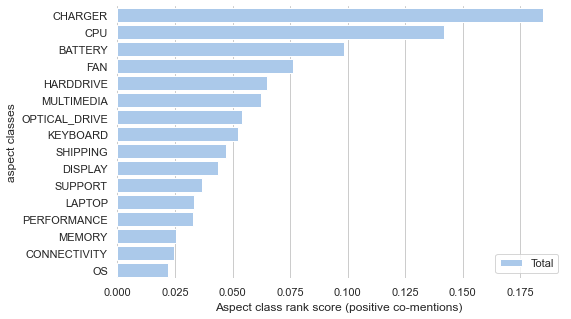

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# data=df_all_pagerank

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="rank", y="aspect_class", data=df_pos_pagerank,
            label="Total", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="aspect classes", xlabel="Aspect class rank score (positive co-mentions) ")
# ax.set(xlim=(0, 1), ylabel="aspect classes", xlabel="Aspect class rank score (positive co-mentions) ")
sns.despine(left=True, bottom=True)